## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.


In [21]:
### Environment setup
from pystac_client import Client
import planetary_computer as pc
import os
import fsspec

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value
    
container = 'itv-data'

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}

fs = fsspec.filesystem('az', account_name=storage_options['account_name'], account_key=storage_options['account_key'])   

In [23]:
import sys
sys.path.append('/content')
from src.fluvius import WaterData, WaterStation
%load_ext autoreload
%autoreload 2

import pandas as pd
import fsspec
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}

data_source = 'itv'
container = f'{data_source}-data'
ds = WaterData(data_source, container, storage_options)
ds.get_source_df()
buffer_distance = 500 #in meters
ds.apply_buffer_to_points(buffer_distance)
ds.generate_map()
ds.plot_map

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [25]:
ds.get_station_data() #apply to all stations in the list


In [50]:
station = 'ITV5'
cloud_thr = 80
day_tolerance = 8
ds.station[station].get_cloud_filtered_image_df(cloud_thr)
ds.station[station].merge_image_df_with_samples(day_tolerance)
ds.station[station].get_reflectances()
ds.station[station].merged_df

#site = str(station['site_no']).zfill(8)
#write_url = f'az://{container}/stations/{site}/{site}.csv'

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


,Campaign,Campaign Date,Drainage Area (km²),SSC (mg/l),Q (m³/s),Date-Time,Date,Date-Time_Remote,Tile Cloud Cover,visual-href,scl-href,InSitu_Satellite_Diff,sentinel-2-l2a_R,sentinel-2-l2a_G,sentinel-2-l2a_B
5,6.0,23/06/2016,6879.06,12.36,8.52,2016-06-23,2016-06-23,2016-06-15,0.942286,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,8 days,50.494275,53.713740,30.324427
8,9.0,05/04/2017,6879.06,20.23,177.62,2017-05-04,2017-05-04,2017-05-01,28.616547,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,3 days,50.734375,44.697917,26.656250
12,15.0,03/10/2018,6879.06,11.14,4.45,2018-03-10,2018-03-10,2018-03-02,71.703708,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,8 days,63.473485,62.590909,58.647727
14,14.0,28/06/2018,6879.06,10.7,12.96,2018-06-28,2018-06-28,2018-06-25,10.681053,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,3 days,53.269118,57.075000,35.442647
15,16.0,27/01/2019,6879.06,27.16,89.25,2019-01-27,2019-01-27,2019-01-21,77.253001,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,6 days,63.945312,67.562500,69.546875
16,18.0,28/06/2019,6879.06,9.24,20.09,2019-06-28,2019-06-28,2019-06-25,0.013939,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,3 days,45.295752,50.599673,32.243464
17,19.0,07/09/2019,6879.06,3.76,6.16,2019-07-09,2019-07-09,2019-07-05,16.568133,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,4 days,47.609649,56.543860,41.686404
18,17.0,10/04/2019,6879.06,28.35,315.12,2019-10-04,2019-10-04,2019-09-28,33.165413,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,6 days,NaN,NaN,NaN


We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

For example, here we use rasterio to render the image data over our area of interest:

## 0.1.4. Render our AOI from this image

In [ ]:
f, ax = plt.subplots(1,1,figsize=(20,8))
ax.scatter(df['Date-Time'],df['Chip Cloud Pct'])

Get the URL to the 10m resolution visual [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image.

This HREF is a URL is the location of the asset data on Azure Blob Storage. In order to read the data, we'll need to retrieve a Shared Access Signature and supply it as a query parameter. These tokens are generated from the Planetary Computer Data Access API.

We use the planetary-computer package to "sign" our asset HREF with a generated token:

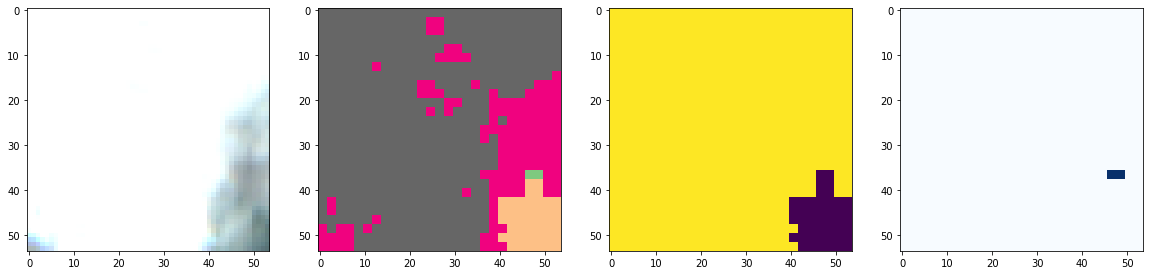

In [126]:
scene_query = df.iloc[3]
visual_href = pc.sign(scene_query['visual-href'])
scl_href = pc.sign(scene_query['scl-href'])
with rasterio.open(scl_href) as ds:    
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
    scl = band_data[0].repeat(2, axis=0).repeat(2, axis=1)

with rasterio.open(visual_href) as ds:    
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    w = img.size[0]; h = img.size[1]; aspect = w/h
    #target_w = img.size[0]*2; target_h = (int)(target_w/aspect)
    target_w = scl.shape[1]; target_h = scl.shape[0]
    img = img.resize((target_w,target_h),Image.BILINEAR)
    

f, ax = plt.subplots(1,4, figsize=(20,20))
cloud_mask = scl>7
water_mask = ((scl==6) | (scl==2))
ax[0].imshow(img)
ax[1].imshow(scl, cmap='Accent')
ax[2].imshow(cloud_mask)
ax[3].imshow(water_mask, cmap='Blues')
    #we can download the image chips here and place them in the usgs-data/{site_no}/

In [109]:
np.mean(np.array(img)[water_mask],axis=0)

array([58.03409091, 57.53787879, 36.66287879])

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting. Given the bounds, we will select the a nxn image around our point of interest

We might be able to create a small semantic segmentation model using our classification layer and then run that first on a scene from landsat...

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,20))
mask = water_mask[..., np.newaxis] * np.ones(np.array(img).shape).astype('bool')
#water = np.ma.MaskedArray(np.array(img), mask=~mask)
water = np.array(img)
water[~mask] =255 
ax.imshow(water)

In [4]:
#we might add a line to the gdf to include total number of cloud free chips?
#task is to open each site_no and the get the df of the estimates and then look at the cloud cover average
date_range_list = []
cloudless_count_list = []
site_no_list = []
for i, station in gdf.iterrows():
    site = str(station.site_no).zfill(8)
    url = f'az://{container}/stations/{site}/{site}.csv' #zero pad 8 digits for site_no
    try:
        df = pd.read_csv(url, storage_options=storage_options) 
        df['Date-Time'] = pd.to_datetime(df['Date-Time'])
        df = df.sort_values(by='Date-Time')
        if len(df)>0:
            #Define the aoi and time range to filter images with. 
            area_of_interest, time_of_interest = get_spacetime_bounds(station)
            cloud_thr = 5
            cloud_chip_count = len(df[df['Chip Cloud Pct']<cloud_thr])
            cloudless_count_list.append(cloud_chip_count)
            date_range_list.append(time_of_interest)
            site_no_list.append(int(site))
    except:
        print(f'{url} does not exist')
    
meta = pd.DataFrame({'site_no':site_no_list, 'cloudless_img_count':cloudless_count_list, 'date_range':date_range_list})
station_url = f'az://{container}/station_img_metadata.csv'
out = gdf.merge(meta, on='site_no').to_csv(station_url, storage_options=storage_options, index=False )

az://itv-data/stations/0000ITV1/0000ITV1.csv does not exist
az://itv-data/stations/0000ITV2/0000ITV2.csv does not exist
az://itv-data/stations/0000ITV3/0000ITV3.csv does not exist
az://itv-data/stations/0000ITV5/0000ITV5.csv does not exist
az://itv-data/stations/0000ITV6/0000ITV6.csv does not exist
az://itv-data/stations/0000ITV7/0000ITV7.csv does not exist
az://itv-data/stations/0000ITV8/0000ITV8.csv does not exist
az://itv-data/stations/0000ITV9/0000ITV9.csv does not exist
az://itv-data/stations/000ITV10/000ITV10.csv does not exist
az://itv-data/stations/000ITV11/000ITV11.csv does not exist
az://itv-data/stations/000ITV12/000ITV12.csv does not exist
az://itv-data/stations/000ITV13/000ITV13.csv does not exist
az://itv-data/stations/000ITV14/000ITV14.csv does not exist
az://itv-data/stations/000ITV15/000ITV15.csv does not exist
az://itv-data/stations/000ITV16/000ITV16.csv does not exist


ValueError: arrays must all be same length

In [5]:
np.sum(meta.cloudless_img_count)
#ana data extremely sparse for cloud free!
#trigger for planet purchase....

NameError: name 'meta' is not defined